# Evidencia 2 - Análisis de aprendizaje automático

Equipo Ctrl+4

Alejandro Preisser Roca | A01706272

Aranza Jimena Martinez Jiménez | A01769455

Ian Julián Estrada Castro | A01352823

Jerónimo López Ibarrarán | A01709519


# Contexto y datos

Planificación de la demanda de la operación logistica con un enfoque en buffering

## LogiMayab

Proveedor de soluciones en transporte de carga terrestre con más de 30 años de experiencia ofreciendo un servicio puntual, seguro y personalizado.

Logística del Mayab S.A. de C.V. es una empresa del servicio Público Federal autorizada para la explotación del transporte de carga en rutas de jurisdicción Federal y Local. Inicia sus actividades el 27 de Febrero del 2004. anteriormente figuraba como TEPSA, contamos
con más de 20 años de experiencia

Propuesta de valor: Servicio puntual, seguro y personalizado.

LogiMayab, es una empresa mexicana especializada en soluciones logísticas y de transporte. Su enfoque principal es ofrecer servicios integrales de distribución de productos mediante los cuales se incluye el almacenamiento, manejo de inventarios y transporte, con el fin de garantizar entregas seguras, oportunas y  eficientes. Buscan la satisfacción desde pequeñas empresas hasta grandes corporativos. (Logi Mayab inglés, 2025)

### Servicios
SERVICIO DE CARGA: Dedicada garantizando disponibilidad

TRANSPORTE REFRIGERADO: para productos fríos y congelados

## Objetivo del modelo

El objetivo es desarrollar un modelo capáz de hacer pronóstico de la demanda para las rutas que presentan mayor variabilidad, con la finalidad de anticipar la demanda de viajes en estas rutas de forma confiable y permita implementar buffers.

## Evaluación de datos

Primero preparamos el entorno lo suficiente para cargar nuestra base de datos

In [ ]:
!pip install pmdarima -q
!pip install pystan==2.19.1.1
!pip install prophet

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [ ]:
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import pandas as pd

In [2]:
Rep_Viajes = pd.read_csv('../data/Reporte_Listado_Viajes_Ene-Oct-25.csv')
Rep_Viajes

,Numero,Nombre Cliente,Folio,Ruta,Viaje,Viaje Docto,Sucursal,No. Viaje Cte,Fecha,Moneda,...,Nro Ope,Operador,Fecha Salida,Fecha Llegada,Peso Kgs,Peso Descarga Kgs,Diferencia,Documentos,UUID CP,Estatus de Viaje
0,1,EMBOTELLADORAS BEPENSA,105,BB PACABTUN/BB CIUDAD DEL CARMEN,LM/MID-000001659,CARTA PORTE CFDI 000000001659-CPMID,MERIDA/YUC001,6919,1/1/2025,PESOS,...,3798.0,GAMBOA FIERRO ALEJANDRO,1/1/25 18:50,1/2/25 5:17,"54,000.00",NaN,"54,000.00",NaN,NaN,TERMINADO
1,1,EMBOTELLADORAS BEPENSA,105,BB CIUDAD DEL CARMEN/BB PACABTUN,LM/MID-000001659,CARTA PORTE CFDI 000000001659-CPMID,MERIDA/YUC001,6919,1/1/2025,PESOS,...,3798.0,GAMBOA FIERRO ALEJANDRO,1/2/25 9:30,1/2/25 16:41,"54,000.00",NaN,"54,000.00",NaN,NaN,TERMINADO
2,1,EMBOTELLADORAS BEPENSA,199,BB PACABTUN/BB CAMPECHE OTE,LM/MID-000001661,CARTA PORTE CFDI 000000001661-CPMID,MERIDA/YUC001,5717,1/1/2025,PESOS,...,58816.0,CASTILLO DIAZ OMAR SALVADOR,1/2/25 0:35,1/2/25 3:02,"54,000.00",NaN,"54,000.00",NaN,NaN,TERMINADO
3,1,EMBOTELLADORAS BEPENSA,199,BB CAMPECHE OTE/BB PACABTUN,LM/MID-000001661,CARTA PORTE CFDI 000000001661-CPMID,MERIDA/YUC001,5717,1/1/2025,PESOS,...,58816.0,CASTILLO DIAZ OMAR SALVADOR,1/2/25 3:50,1/2/25 6:21,"54,000.00",NaN,"54,000.00",NaN,NaN,TERMINADO
4,1,EMBOTELLADORAS BEPENSA,204,BB PACABTUN/BB PLAYA DEL CARMEN,LM/MID-000001660,CARTA PORTE CFDI 000000001660-CPMID,MERIDA/YUC001,5716,1/1/2025,PESOS,...,1334.0,DIAZ ECHEVERRIA ALEJANDRO DE JESUS,1/1/25 23:20,1/2/25 9:30,"54,000.00",NaN,"54,000.00",NaN,NaN,TERMINADO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108986,1322,NUEVA WAL MART DE MEXICO,2178,WM CEDIS GUADALAJARA/BKHL BONAFONT,LM/MIDCG-000011717,CARTA PORTE 000000005220-VYUC,MERIDA CG/YUC007,IDID22495550,10/27/2025,PESOS,...,58257.0,PEREZ PALACIOS GABRIEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108987,1322,NUEVA WAL MART DE MEXICO,2217,CEDIS PERECEDEROS VHS/WM SANTA FE,LM/ARR-000012440,CARTA PORTE CFDI 000000004382-CPVHS,CARDARRAS/TAB005,R6295,10/27/2025,PESOS,...,58213.0,DE LA ROSA SOBERANO DAVID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108988,1322,NUEVA WAL MART DE MEXICO,2367,MATTEL DE MEXICO/CEDIS WM MID TEYA,LM/MIDCG-000011723,CARTA PORTE CFDI 000000006500-CPYUC,MERIDA CG/YUC007,8700197,10/27/2025,PESOS,...,45028.0,ZETINA UC JOSE DE LA CRUZ,NaN,NaN,"50,837.84","50,837.84",NaN,NaN,NaN,FACTURADO
108989,1587,LA MADRILEÑA,2289,"LA MADRILEÑA, SAN JUAN DEL RIO/IZTAPALAPA, DIS...",LM/QRO-000001595,CARTA PORTE CFDI 000000001592-CPQRO,QUERETARO/QRO003,MADOLE021014,10/27/2025,PESOS,...,58902.0,TAMANIZ AMADOR MARTIN,NaN,NaN,"20,000.00","20,000.00",NaN,NaN,NaN,FACTURADO


Lo primero que verificamos es utilizar un info para inspeccionar el formato y cantidad de registros inicial de las variables.  

In [ ]:
Rep_Viajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108991 entries, 0 to 108990
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Numero             108991 non-null  int64  
 1   Nombre Cliente     108991 non-null  object 
 2   Folio              108991 non-null  int64  
 3   Ruta               108991 non-null  object 
 4   Viaje              108991 non-null  object 
 5   Viaje Docto        108991 non-null  object 
 6   Sucursal           108991 non-null  object 
 7   No. Viaje Cte      108991 non-null  object 
 8   Fecha              108991 non-null  object 
 9   Moneda             108991 non-null  object 
 10  SubTotal           108991 non-null  object 
 11  IVA                108991 non-null  object 
 12  Retención          108991 non-null  object 
 13  Total              108991 non-null  object 
 14  Factura            105298 non-null  object 
 15  Liquidación        72998 non-null   object 
 16  Fe

La gran mayoría de las columnas se encuentran en un formato inadecuado, por lo que en la limpieza tendremos que reformatear la gran mayoría de las variables para poderlas manipular.

 Ahora, se lleva a cabo una búsqueda de nulos que tenemos por cada columna, con tal de identificar donde debemos de intervenir durante la limpieza.

In [ ]:
Rep_Viajes.isna().mean()*100

,0
Numero,0.000000
Nombre Cliente,0.000000
Folio,0.000000
Ruta,0.000000
Viaje,0.000000
Viaje Docto,0.000000
Sucursal,0.000000
No. Viaje Cte,0.000000
Fecha,0.000000
Moneda,0.000000


Debemos inspeccionar las cualidades de las variables en formato object para identificar cuáles son de utilidad, al igual que tener una comprensión general de sus valores.

In [ ]:
Rep_Viajes.describe(include=['object']).T

,count,unique,top,freq
Nombre Cliente,108991,21,NUEVA WAL MART DE MEXICO,59899
Ruta,108991,2714,WM CEDIS CHALCO/WM BODEGA REMOTA CHALCO,3813
Viaje,108991,84188,LM/ARR-000005322,8
Viaje Docto,108991,84188,CARTA PORTE CFDI 000000001900-CPVHS,8
Sucursal,108991,8,MERIDA/YUC001,31686
No. Viaje Cte,108991,84096,1,9
Fecha,108991,301,1/28/2025,694
Moneda,108991,1,PESOS,108991
SubTotal,108991,21342,$0.00,26259
IVA,108991,16485,$0.00,26260



 Los puntos clave que debemos tomar en consideración de la base de datos son los siguientes:

* **Clientes** : Tienen un total de 21 clientes.
* **Rutas**: Operan en 2714 rutas, las cuáles son 1357 caminos de ida y vuelta.
* **Sucursales**: Operan a través de 8 sucursales distintas.
* **Tractocamión** Cuentan con 348 unidades.
* **Fechas**: Abarca desde el 1/01/2025 al 27/10/2025
* **Demanda**: Para estimar la demanda se va considerar la cantidad de viajes registrados en este DataFrame.

# Implementación del modelo seleccionado
El modelo a utilizar es ARIMA (Media Móvil Integrada Autoregresiva), la cual se utilizó para dos de nuestras pruebas de hipótesis. Nuestro pronóstico se basa en la variabilidad de las rutas a través de una serie de tiempo de los viajes realizados diariamente en una ruta particular.






El modelo ARIMA, su abreviatura significa Autorregresivo(AR) integrada(I) Media móvil(MA) es en realidad una clase de modelos que 'explica' una serie de tiempo determinada en función de sus propios valores pasados, es decir, sus propios retrasos y los errores de pronóstico retrasados, de modo que se puede utilizar la ecuación para pronosticar valores futuros.

Cualquier serie de tiempo "no estacional" que muestre patrones y no sea un "ruido blanco" aleatorio se puede modelar con modelos ARIMA.

Un modelo ARIMA se caracteriza por 3 términos: p, d, q

* p: es el orden del término AR

* q: es el orden del término MA

* d: es el número de diferenciaciones necesarias para que la serie de tiempo sea estacionaria

Si una serie de tiempo tiene patrones estacionales, entonces necesita agregar términos estacionales y se convierte en SARIMA, abreviatura de "Seasonal ARIMA".

Con la finalidad de implementar un método inovador en el mundo de la modelación, también se planea utilizar Prophet.
Prophet es un modelo de regresión aditiva diseñada para series temporales, está compuesta por una tendencia no lineal, estacionalidad y error.
El razonamiento detrás de utilizarlo es que es un modelo resistente ante conjuntos de datos con valores atípicos, al igual que es simple de implementar.

### Preparación del entorno

### Carga de dataframe

In [ ]:
Rep_Viajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108991 entries, 0 to 108990
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Numero             108991 non-null  int64  
 1   Nombre Cliente     108991 non-null  object 
 2   Folio              108991 non-null  int64  
 3   Ruta               108991 non-null  object 
 4   Viaje              108991 non-null  object 
 5   Viaje Docto        108991 non-null  object 
 6   Sucursal           108991 non-null  object 
 7   No. Viaje Cte      108991 non-null  object 
 8   Fecha              108991 non-null  object 
 9   Moneda             108991 non-null  object 
 10  SubTotal           108991 non-null  object 
 11  IVA                108991 non-null  object 
 12  Retención          108991 non-null  object 
 13  Total              108991 non-null  object 
 14  Factura            105298 non-null  object 
 15  Liquidación        72998 non-null   object 
 16  Fe

## Tipos de datos
Las variables numéricas, los costos, cuentan con caracteres que impiden convertirlos directmante a un dato numérico.

Las fechas se leyeron como objetos. Es muy importante transformarlas a datetime para hacer operaciones.

In [ ]:
Rep_Viajes['SubTotal'] = Rep_Viajes["SubTotal"].replace('[\$,]', '', regex=True).astype(float)
Rep_Viajes['IVA'] = Rep_Viajes['IVA'].replace('[\$,]', '', regex=True).astype(float)
Rep_Viajes['Retención'] = Rep_Viajes["Retención"].replace('[\$,]', '', regex=True).astype(float)
Rep_Viajes['Total'] = Rep_Viajes['Total'].replace('[\$,]', '', regex=True).astype(float)
Rep_Viajes['Liquidación'] = Rep_Viajes['Liquidación'].replace('[\$,]', '', regex=True).astype(float)
Rep_Viajes['Peso Kgs'] = Rep_Viajes['Peso Kgs'].str.replace(',', '', regex=False).astype(float)
Rep_Viajes['Peso Descarga Kgs'] = Rep_Viajes['Peso Descarga Kgs'].str.replace(',', '', regex=False).astype(float)
Rep_Viajes['Diferencia'] = Rep_Viajes['Diferencia'].str.replace(',', '', regex=False).astype(float)
Rep_Viajes['Fecha'] = pd.to_datetime(Rep_Viajes['Fecha'],format='mixed',dayfirst=False)
Rep_Viajes['Fecha.1'] = pd.to_datetime(Rep_Viajes['Fecha.1'],format='mixed',dayfirst=False)
Rep_Viajes['Fecha Vencimiento'] = Rep_Viajes['Fecha Vencimiento'].str.replace(r'/\d{4}$', '/2025', regex=True)
Rep_Viajes['Fecha Vencimiento'] = pd.to_datetime(Rep_Viajes['Fecha Vencimiento'],format='mixed',dayfirst=False)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2410745117.py:1: SyntaxWarning: invalid escape sequence '\$'
  Rep_Viajes['SubTotal'] = Rep_Viajes["SubTotal"].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipython-input-2410745117.py:2: SyntaxWarning: invalid escape sequence '\$'
  Rep_Viajes['IVA'] = Rep_Viajes['IVA'].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipython-input-2410745117.py:3: SyntaxWarning: invalid escape sequence '\$'
  Rep_Viajes['Retención'] = Rep_Viajes["Retención"].replace('[\$,]', '', reg

In [ ]:
Rep_Viajes = Rep_Viajes.rename(columns={'Numero':'Cliente'})

In [ ]:
Rep_Viajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108991 entries, 0 to 108990
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Cliente            108991 non-null  int64         
 1   Nombre Cliente     108991 non-null  object        
 2   Folio              108991 non-null  int64         
 3   Ruta               108991 non-null  object        
 4   Viaje              108991 non-null  object        
 5   Viaje Docto        108991 non-null  object        
 6   Sucursal           108991 non-null  object        
 7   No. Viaje Cte      108991 non-null  object        
 8   Fecha              108991 non-null  datetime64[ns]
 9   Moneda             108991 non-null  object        
 10  SubTotal           108991 non-null  float64       
 11  IVA                108991 non-null  float64       
 12  Retención          108991 non-null  float64       
 13  Total              108991 non-null  float64 

## Duplicados
Asimismo, contamos con registros duplicados los cuales eliminaremos y mantendremos únicamente el primer registro.

In [ ]:
Rep_Viajes.duplicated().sum()

np.int64(13)

In [ ]:
Rep_Viajes_sindupes = Rep_Viajes.drop_duplicates(keep='first')

In [ ]:
Rep_Viajes_sindupes.duplicated().sum()

np.int64(0)

## Limpieza
Esta operación es necesaria para asegurar la calidad de los datos.

El comando anterior muestra un conjunto de datos con 2 variables que tienen 0 registros, por lo que borraremos las columnas 'Documentos' y 'UUID CP' del dataframe.

In [ ]:
Rep_Viajes_limpia = Rep_Viajes_sindupes.copy()

In [ ]:
Rep_Viajes_limpia = Rep_Viajes_limpia.drop(columns=['UUID CP', 'Documentos'])

Eliminaremos las columnas que no utilizaremos para el modelo, dado el enfoque de nuestro modelo, las variables más importantes son las que nos permiten componer un valor de demanda con identificadores clave, de unidad, cliente (en número), ruta, fecha y total.

In [ ]:
columnas_a_eliminar = ['Nombre Cliente',
                       'Diferencia',
                       'Liquidación',
                       'Dolly',
                       'Remolque 2',
                       'Operador',
                       'Peso Kgs',
                       'Peso Descarga Kgs',
                       'Moneda',
                       'Viaje Docto',
                       'Fecha.1',
                       'Fecha Vencimiento',
                       'Remolque 1',
                       'Fecha Salida',
                       'Fecha Llegada',
                       'Estatus de Viaje',
                       'Retención',
                       'Factura',
                       'SubTotal',
                       'IVA',
                       'Viaje Docto',
                       'Operador',
                       'Nro Ope']

Rep_Viajes_limpia = Rep_Viajes_limpia.drop(columns=columnas_a_eliminar)

In [ ]:
Rep_Viajes_limpia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108978 entries, 0 to 108990
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Cliente        108978 non-null  int64         
 1   Folio          108978 non-null  int64         
 2   Ruta           108978 non-null  object        
 3   Viaje          108978 non-null  object        
 4   Sucursal       108978 non-null  object        
 5   No. Viaje Cte  108978 non-null  object        
 6   Fecha          108978 non-null  datetime64[ns]
 7   Total          108978 non-null  float64       
 8   Tractocamión   108081 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 8.3+ MB


## Tratamiento de datos faltantes
Será indispensable que los registros tengan un tracto asignado para nuestro análisis. No queremos perder esos registros de fecha, por lo que rellenamos las variables con 'Desconocido'.

In [ ]:
Rep_Viajes_limpia.isna().mean()*100

,0
Cliente,0.000000
Folio,0.000000
Ruta,0.000000
Viaje,0.000000
Sucursal,0.000000
No. Viaje Cte,0.000000
Fecha,0.000000
Total,0.000000
Tractocamión,0.823102


Imputación de variables: Dado que el ID de tracto y

In [ ]:
Rep_Viajes_limpia['Tractocamión'] = Rep_Viajes_limpia['Tractocamión'].fillna('Desconocido')

In [ ]:
Rep_Viajes_limpia.isna().mean()*100

,0
Cliente,0.0
Folio,0.0
Ruta,0.0
Viaje,0.0
Sucursal,0.0
No. Viaje Cte,0.0
Fecha,0.0
Total,0.0
Tractocamión,0.0


## Tratamiento de ouliers
Será indispensable que los registros tengan un tracto asignado para nuestro análisis y dada la poca cantidad de nulos, podemos eliminar esos registros sin afectar gravemente nuestra base de datos

<Axes: >

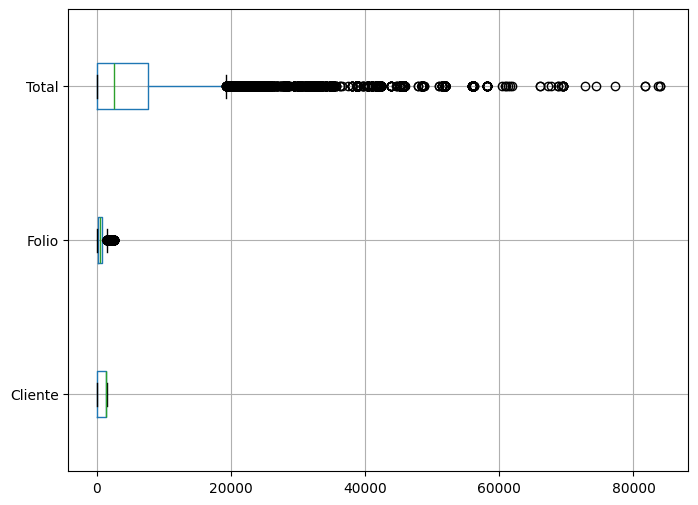

In [ ]:
Rep_Viajes_limpia.boxplot(figsize=(8,6), vert=False)

Folio y Número son nominales, la que nos interesa es Total. A pesar de que la variable Total presenta datos aparentemente atípicos según el IQR, los valores son de los viajes más caros que correspondían a...


En este caso, haremos un escalamiento logarítmico

## Transformación
Haremos un escalamiento logarítmico a la variable Total, la cual llamaremos 'Total_log'

In [ ]:
Rep_Viajes_limpia['Total_log'] = np.log1p(Rep_Viajes_limpia['Total'])

<Axes: >

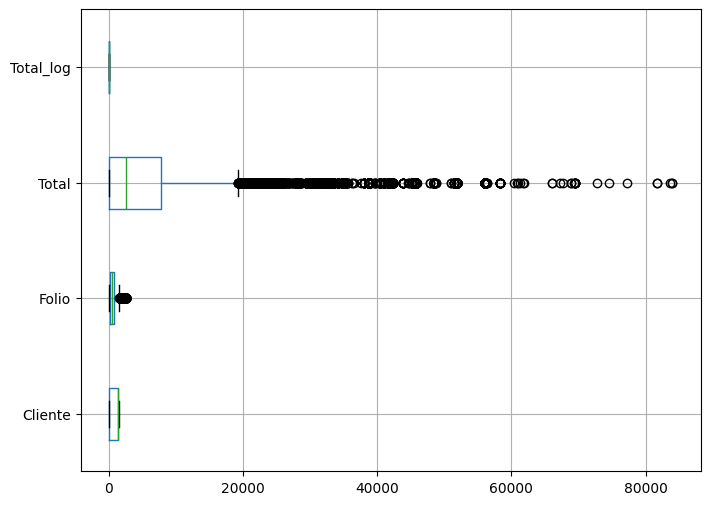

In [ ]:
Rep_Viajes_limpia.boxplot(figsize=(8,6), vert=False)

## Otras variables

**Variabilidad por ruta**

In [ ]:
KPIS = Rep_Viajes_limpia.copy()
def normalizar_ruta(r):
    try:
        a, b = r.split('/')
        return ' / '.join(sorted([a.strip(), b.strip()]))
    except:
        return r  # por si alguna fila no trae el formato esperado

KPIS['Ruta_norm'] = KPIS['Ruta'].apply(normalizar_ruta)

# Ahora obtienes el top de rutas normalizadas
KPIS['Ruta_norm'].value_counts().nlargest(50)

,count
Ruta_norm,
WM BODEGA REMOTA CHALCO / WM CEDIS CHALCO,7433
BB PACABTUN / BB PONIENTE,4687
PENSION SALINAS CRUZ / WM CEDIS VILLAHERMOSA SECOS,2877
BB CANCUN PLANTA / BB PLAYA DEL CARMEN,2849
FABRICA DE JABON LA CORONA / WM CEDIS CHALCO,2741
BB CAMPECHE OTE / BB PACABTUN,2136
BB CANCUN PLANTA / BB PACABTUN,1922
BB PACABTUN / BB TICUL,1916
BB CANCUN PLANTA / BB CHETUMAL,1645


In [ ]:
KPIS['Mes'] = KPIS['Fecha'].dt.to_period('M')
viajes_mensuales_ruta = (KPIS
                    .groupby(['Ruta_norm', 'Mes'])
                    .size()
                    .reset_index(name='ViajesRuta'))
viajes_mensuales_ruta = (KPIS
                    .groupby(['Ruta_norm', 'Mes'])
                    .size()
                    .reset_index(name='ViajesRuta'))


print("Primeras 5 filas de los viajes mensuales recalculados del DataFrame:")
print(viajes_mensuales_ruta.head())

Primeras 5 filas de los viajes mensuales recalculados del DataFrame:
                                          Ruta_norm      Mes  ViajesRuta
0                      14 ORIENTE / WM CEDIS CHALCO  2025-05           2
1             7 ELEVEN CANCUN / CERVECERIA YUCATECA  2025-02           1
2             7 ELEVEN CANCUN / LOGISTICA DEL MAYAB  2025-02           1
3  ABSORMEX CMPC TISSUE / BODEGA ANGELES IZTAPALAPA  2025-08           1
4        ABSORMEX CMPC TISSUE / SAMS CLUB CD JARDIN  2025-09           1


In [ ]:
cv_por_ruta = viajes_mensuales_ruta.groupby('Ruta_norm')['ViajesRuta'].agg(
    lambda x: x.std() / x.mean()
)
cv_por_ruta.sort_values(ascending=False).head(50)

,ViajesRuta
Ruta_norm,
WM BODEGA REMOTA AYOTLA / WM CEDIS CHALCO,2.258474
PATIO TIP PERAL / WM CEDIS CHALCO,2.091321
BB PACABTUN / MEGA EMPACK,1.666667
AURRERA CHUBURNA / WM CEDIS MID TEYA,1.657614
CEDIS PERECEDEROS VHS / WM CEDIS VILLAHERMOSA SECOS,1.655660
AURRERA ITZAES / WM CEDIS MID TEYA,1.631458
FREUHAUF CARTAGENA / WM CEDIS CHALCO,1.421530
WM CEDIS MEGAPARK IDC / WM CEDIS SAN MARTIN OBISPO,1.369306
TIP MEXICO CONVENTO / WM CEDIS CHALCO,1.359821


# Entrenamiento y evaluación

## Preparación de los datos

In [ ]:
n_top_rutas = 10
top_rutas_variables = cv_por_ruta.sort_values(ascending=False).head(n_top_rutas).index.tolist()
print(f"Las {n_top_rutas} rutas con mayor variabilidad en la demanda mensual de viajes son:\n{top_rutas_variables}")

Las 10 rutas con mayor variabilidad en la demanda mensual de viajes son:
['WM BODEGA REMOTA AYOTLA / WM CEDIS CHALCO', 'PATIO TIP PERAL / WM CEDIS CHALCO', 'BB PACABTUN / MEGA EMPACK', 'AURRERA CHUBURNA / WM CEDIS MID TEYA', 'CEDIS PERECEDEROS VHS / WM CEDIS VILLAHERMOSA SECOS', 'AURRERA ITZAES / WM CEDIS MID TEYA', 'FREUHAUF CARTAGENA / WM CEDIS CHALCO', 'WM CEDIS MEGAPARK IDC / WM CEDIS SAN MARTIN OBISPO', 'TIP MEXICO CONVENTO / WM CEDIS CHALCO', 'WM CEDIS MID TEYA / WM MERIDA NORTE']


/tmp/ipython-input-1756186185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cv_por_ruta[top_rutas_variables].values, y=cv_por_ruta[top_rutas_variables].index, palette='viridis')


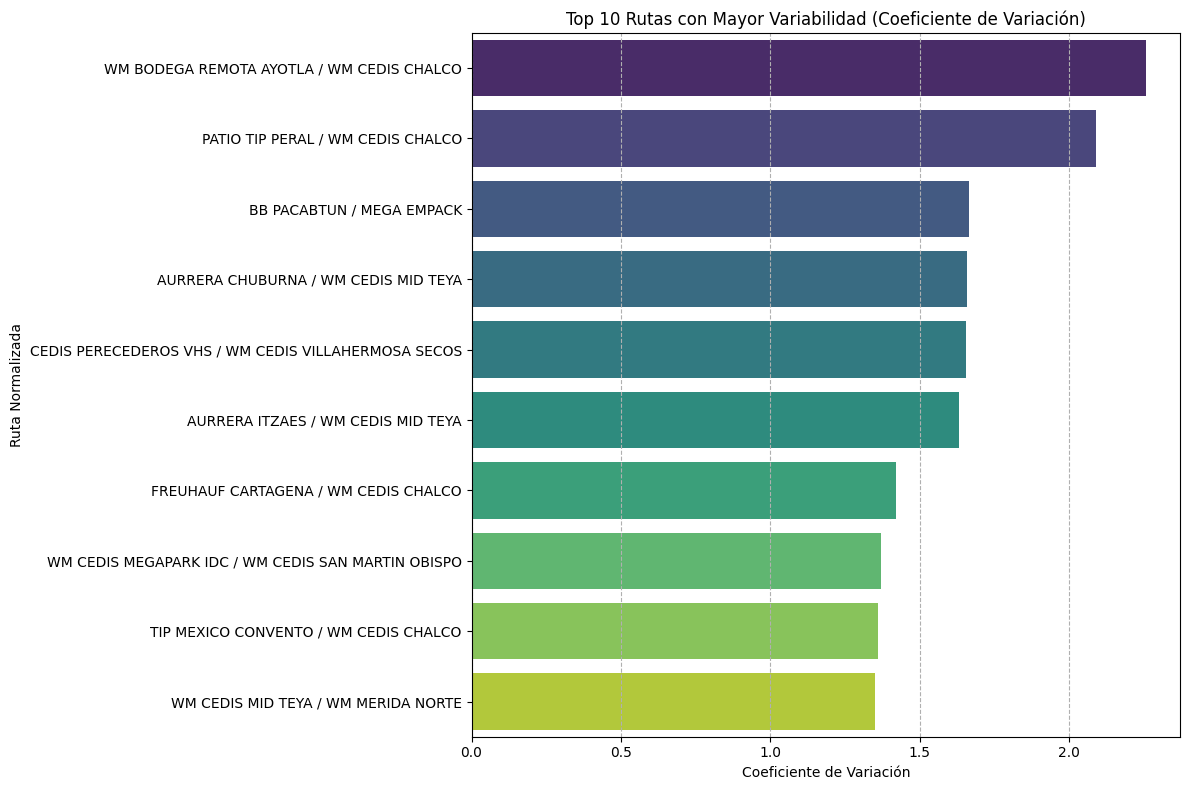

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=cv_por_ruta[top_rutas_variables].values, y=cv_por_ruta[top_rutas_variables].index, palette='viridis')
plt.title('Top 10 Rutas con Mayor Variabilidad (Coeficiente de Variación)')
plt.xlabel('Coeficiente de Variación')
plt.ylabel('Ruta Normalizada')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

Acotamos la serie de tiempo para viajes a únicamente incluir las rutas que presentan mayor variabilidad en su demanda.

In [ ]:
Rep_Viajes_limpia['Ruta_norm'] = Rep_Viajes_limpia['Ruta'].apply(normalizar_ruta)

In [ ]:
viajes_diarios_top_rutas = Rep_Viajes_limpia[Rep_Viajes_limpia['Ruta_norm'].isin(top_rutas_variables)].groupby('Fecha').size().reset_index(name='Viajes')
viajes_diarios_top_rutas.head(10)

,Fecha,Viajes
0,2025-01-01,2
1,2025-01-02,33
2,2025-01-03,66
3,2025-01-04,70
4,2025-01-05,27
5,2025-01-06,76
6,2025-01-07,47
7,2025-01-08,28
8,2025-01-09,42
9,2025-01-10,27


In [ ]:
viajes_diarios_top_rutas

,Fecha,Viajes
0,2025-01-01,2
1,2025-01-02,33
2,2025-01-03,66
3,2025-01-04,70
4,2025-01-05,27
...,...,...
158,2025-10-22,1
159,2025-10-23,3
160,2025-10-24,9
161,2025-10-25,1


In [ ]:
viajes_diarios_top_rutas.to_csv('Viajes_Diarios_Top_Rutas_Volatiles.csv')

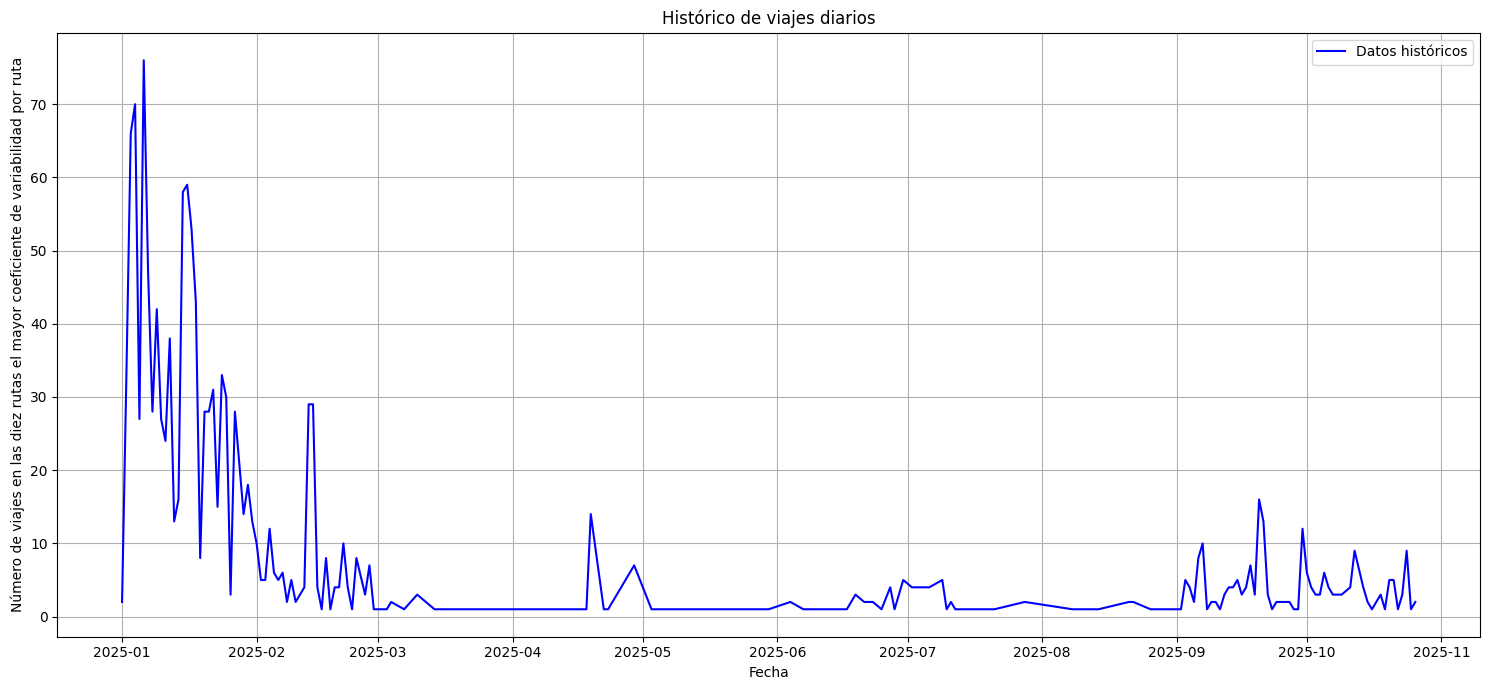

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='Fecha', y='Viajes', data=viajes_diarios_top_rutas, label='Datos históricos', color='blue')
plt.title('Histórico de viajes diarios')
plt.xlabel('Fecha')
plt.ylabel('Número de viajes en las diez rutas el mayor coeficiente de variabilidad por ruta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Separamos nuestra serie de tiempo en un conjunto de datos de entrenamiento de 80% y un 20% de datos de prueba. Como en este caso estamos trabajando con series de tiempo, el split no puede ser aleatorio, sino que se toma de un periodo para el que si tenemos datos.

In [ ]:
n = len(viajes_diarios_top_rutas)
split_point = int(len(viajes_diarios_top_rutas) * 0.8)

train_data = viajes_diarios_top_rutas.iloc[:split_point]
test_data = viajes_diarios_top_rutas.iloc[split_point:]

print(f'Train: {train_data.shape}')
print(f'Test: {test_data.shape}')

Train: (130, 2)
Test: (33, 2)


## ARIMA
Metemos nuestra serie de tiempo a un Arima utilizando auto_arima, este prueba diferentes combinaciones de parámetros hasta encontrar la mejor combinación para nuestro conjunto de datos.


In [ ]:
model = pm.auto_arima(train_data['Viajes'], seasonal=False, suppress_warnings=True,
                      stepwise=True, trace=False, error_action='ignore')

print('Entrenamiento de modelo ARIMA')
display(model.summary())
print(f"ARIMA parametros (p, d, q): {model.order}")

Entrenamiento de modelo ARIMA


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -474.506
Date:                Fri, 05 Dec 2025   AIC                            961.012
Time:                        06:15:02   BIC                            978.171
Sample:                             0   HQIC                           967.984
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0299      0.030    -34.635      0.000      -1.088      -0.972
ar.L2         -0.9580      0.019    -49.614      0.000      -0.996      -0.920
ma.L1          0.4164      0.107      3.908      0.000       0.208       0.625
ma.L2          0.0800      0.104      0.769      0.442      -0.124       0.284
ma.L3         -0.7303      0.109     -6.687      0.000      -0.944      -0.516
sigma2        88.6978     11.808      7.512      0.000      65.556     111.840
===================================================================================
Ljung-Box (L1) (Q):                   5.07   Jarque-Bera (JB):                97.51
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA parametros (p, d, q): (2, 1, 3)


In [ ]:
n_periodos_forecast = 14
valores_forecast, int_conf = model.predict(n_periods=n_periodos_forecast, return_conf_int=True)

ultima_fecha_entrenamiento = train_data['Fecha'].max()
fechas_forecast = pd.date_range(start=ultima_fecha_entrenamiento + pd.Timedelta(days=1), periods=n_periodos_forecast, freq='D')

forecast_df = pd.DataFrame({
    'Fecha': fechas_forecast,
    'Viajes_Forecast': valores_forecast,
    'Lower_CI': int_conf[:, 0],
    'Upper_CI': int_conf[:, 1]
})

print('Pronóstico de 14 días con intervalo de confianza de 95%:')

display(forecast_df)

Pronóstico de 14 días con intervalo de confianza de 95%:


,Fecha,Viajes_Forecast,Lower_CI,Upper_CI
130,2025-09-21,9.094107,-9.370837,27.559051
131,2025-09-22,7.096153,-12.697315,26.889622
132,2025-09-23,5.867218,-14.094415,25.828851
133,2025-09-24,9.046813,-11.448836,29.542461
134,2025-09-25,6.949510,-14.669023,28.568042
135,2025-09-26,6.063548,-15.711448,27.838544
136,2025-09-27,8.985096,-13.327737,31.297930
137,2025-09-28,6.824994,-16.451904,30.101893
138,2025-09-29,6.250904,-17.176152,29.677960
139,2025-09-30,8.911424,-15.056389,32.879238


Visualizamos nuestro pronóstico

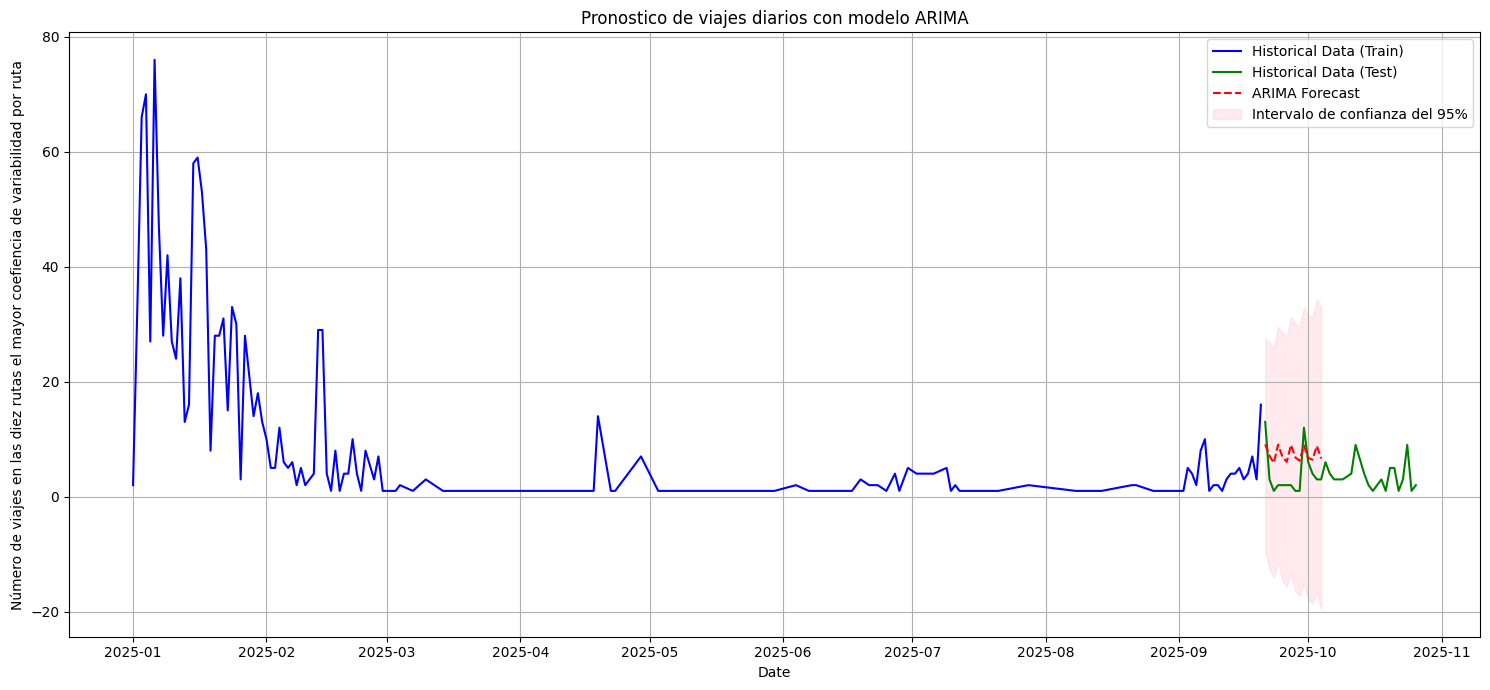

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='Fecha', y='Viajes', data=train_data, label='Historical Data (Train)', color='blue')
sns.lineplot(x='Fecha', y='Viajes', data=test_data, label='Historical Data (Test)', color='green')

plt.plot(forecast_df['Fecha'], forecast_df['Viajes_Forecast'], label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(forecast_df['Fecha'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.3, label='Intervalo de confianza del 95%')

plt.title('Pronostico de viajes diarios con modelo ARIMA')
plt.xlabel('Date')
plt.ylabel('Número de viajes en las diez rutas el mayor coefiencia de variabilidad por ruta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Métricas

Ahora que tenemos un pronóstico, es importante evaluar qué tan acertado es. Las métricas a utilizar son Mean Absolute Error, Root Mean Squared Error, R^2 y R^2 Ajustado.
* **MAE**: es la media de los valores absolutos la diferencia entre el valor real y el valor predicho por el modelo.
* **RMSE** es la raíz cuadrada de la media de los errores al cuadrado.
* **R^2**: representa la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente.
* **R^2 ajustado**: es la raíz cuadrada de la media de los errores al cuadrado en función del número de variables independientes en el modelo. Mide qué tan bien se ajustael modelo a los datos.

In [ ]:
k = 1
n_periods_forecast = 14

actual_values_for_comparison = test_data['Viajes'].head(n_periods_forecast)

predicted_values_for_comparison = valores_forecast.values if isinstance(valores_forecast, pd.Series) else valores_forecast
MAE = mean_absolute_error(actual_values_for_comparison, predicted_values_for_comparison)
RMSE = np.sqrt(mean_squared_error(actual_values_for_comparison, predicted_values_for_comparison))
R2 = r2_score(actual_values_for_comparison, predicted_values_for_comparison)
R2_adjusted = 1 - (((1 - R2) * (n - 1)) / (n - k - 1))

print(f'Mean Absolute Error (MAE): {MAE:.2f}')
print(f'Root Mean Squared Error (RMSE): {RMSE:.2f}')
print(f'R squared (R^2): {R2:.2f}')
print(f'R squared adjusted (R^2 adjusted): {R2_adjusted:.2f}')

Mean Absolute Error (MAE): 4.48
Root Mean Squared Error (RMSE): 4.78
R squared (R^2): -0.64
R squared adjusted (R^2 adjusted): -0.65


El modelo presenta coeficientes significativos al 95% (AR1, AR2, MA1, MA3). Se requieren ajustes ya que el coeficiente de MA2 es no significativo.

* **MAE**: indica que el modelo pronostica en promedio 4 viajes más al día que los registros reales para esos 14 días.
* **RMSE** indica que el modelo pronostica en 4 (casi 5) viajes más al día que los registros reales para esos 14 días.
* **R^2**: recordando que esta métrica no mide dirección de la predicción, -0.64 indica queno existe una relación lineal entre las variables.
* **R^2 ajustado**: similarmente al caso anterior, -0.65 indica queno existe una relación lineal entre las variables e incluso no es un buen modelo.

Dado los resultados anteriores, utilizaremos el modelo de aprendizaje automático Prophet, para buscar un segundo pronóstico.

## Prophet

Separamos el conjunto en datos de entrenamiento y de prueba.

In [ ]:
train_data['ds'] = train_data['Fecha']
train_data['y'] = train_data['Viajes']
train_data

/tmp/ipython-input-1619600361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ds'] = train_data['Fecha']
/tmp/ipython-input-1619600361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y'] = train_data['Viajes']


,Fecha,Viajes,ds,y
0,2025-01-01,2,2025-01-01,2
1,2025-01-02,33,2025-01-02,33
2,2025-01-03,66,2025-01-03,66
3,2025-01-04,70,2025-01-04,70
4,2025-01-05,27,2025-01-05,27
...,...,...,...,...
125,2025-09-16,3,2025-09-16,3
126,2025-09-17,4,2025-09-17,4
127,2025-09-18,7,2025-09-18,7
128,2025-09-19,3,2025-09-19,3


In [ ]:
test_data['ds'] = test_data['Fecha']
test_data['y'] = test_data['Viajes']
test_data

/tmp/ipython-input-2484555924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds'] = test_data['Fecha']
/tmp/ipython-input-2484555924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y'] = test_data['Viajes']


,Fecha,Viajes,ds,y
130,2025-09-21,13,2025-09-21,13
131,2025-09-22,3,2025-09-22,3
132,2025-09-23,1,2025-09-23,1
133,2025-09-24,2,2025-09-24,2
134,2025-09-25,2,2025-09-25,2
135,2025-09-26,2,2025-09-26,2
136,2025-09-27,2,2025-09-27,2
137,2025-09-28,1,2025-09-28,1
138,2025-09-29,1,2025-09-29,1
139,2025-09-30,12,2025-09-30,12


Entrenamos el modelo con el conjunto de datos de entrenamiento.

In [ ]:
prophet = Prophet()
prophet.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=14)
future

,ds
0,2025-01-01
1,2025-01-02
2,2025-01-03
3,2025-01-04
4,2025-01-05
...,...
139,2025-09-30
140,2025-10-01
141,2025-10-02
142,2025-10-03


In [ ]:
prophet_forecast = prophet.predict(future)
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-01-01,21.721771,3.648834,36.498669,21.721771,21.721771,-1.981169,-1.981169,-1.981169,-1.981169,-1.981169,-1.981169,0.0,0.0,0.0,19.740603
1,2025-01-02,21.602993,8.060880,42.222064,21.602993,21.602993,3.469076,3.469076,3.469076,3.469076,3.469076,3.469076,0.0,0.0,0.0,25.072069
2,2025-01-03,21.484214,5.372128,38.179556,21.484214,21.484214,1.589967,1.589967,1.589967,1.589967,1.589967,1.589967,0.0,0.0,0.0,23.074181
3,2025-01-04,21.365436,9.548381,42.122332,21.365436,21.365436,3.396444,3.396444,3.396444,3.396444,3.396444,3.396444,0.0,0.0,0.0,24.761880
4,2025-01-05,21.246658,1.264436,33.665055,21.246658,21.246658,-3.614637,-3.614637,-3.614637,-3.614637,-3.614637,-3.614637,0.0,0.0,0.0,17.632021


Una vez que tenemos el pronóstico, debemos visualizarlo y evaluar su desempeño, utilizando las mismas métricas que para el modelo ARIMA.

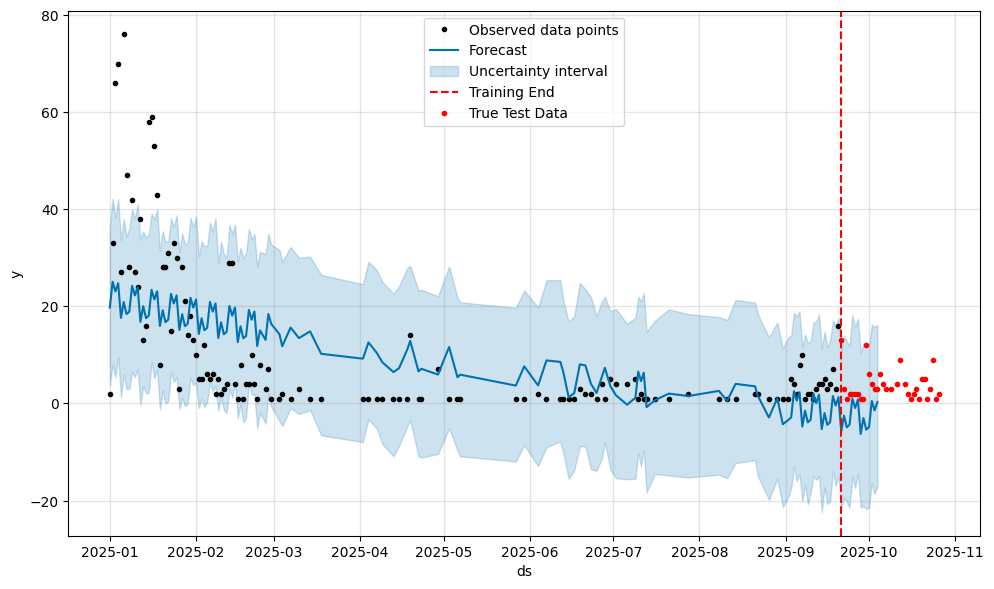

In [ ]:
# plot the time series
forecast_plot = prophet.plot(prophet_forecast)
# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = prophet_forecast['ds'].iloc[-14]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
plt.plot(test_data['Fecha'], test_data['y'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()

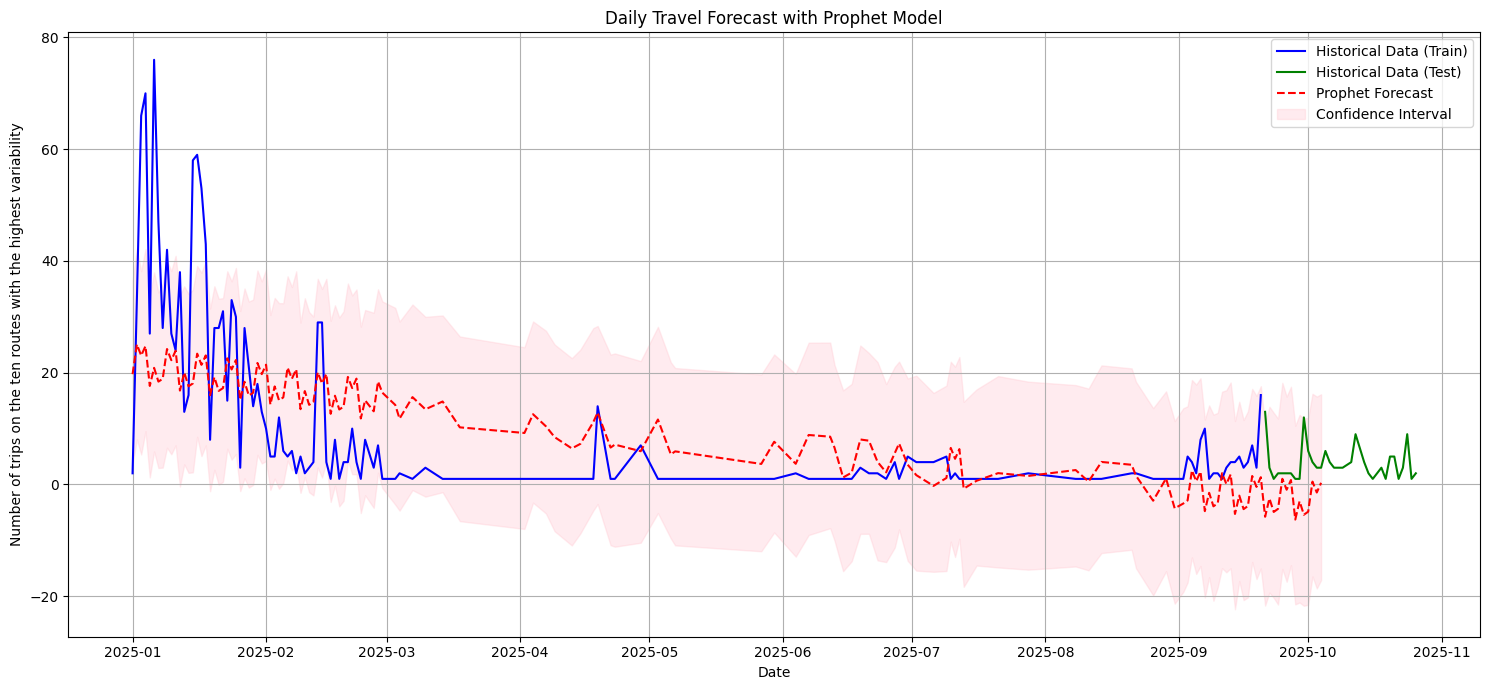

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='Fecha', y='Viajes', data=train_data, label='Historical Data (Train)', color='blue')
sns.lineplot(x='Fecha', y='Viajes', data=test_data, label='Historical Data (Test)', color='green')

# Plot Prophet forecast
sns.lineplot(x='ds', y='yhat', data=prophet_forecast, label='Prophet Forecast', color='red', linestyle='--')
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Daily Travel Forecast with Prophet Model')
plt.xlabel('Date')
plt.ylabel('Number of trips on the ten routes with the highest variability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Métricas

In [ ]:
k = 1
n_periods_forecast = 14

actual_values_for_comparison = test_data['Viajes'].head(n_periods_forecast)

predicted_values_prophet = prophet_forecast['yhat'].tail(n_periods_forecast)

MAE = mean_absolute_error(actual_values_for_comparison, predicted_values_prophet)
RMSE = np.sqrt(mean_squared_error(actual_values_for_comparison, predicted_values_prophet))
R2 = r2_score(actual_values_for_comparison, predicted_values_prophet)

n_comparison = len(actual_values_for_comparison)
R2_adjusted = 1 - (((1 - R2) * (n_comparison - 1)) / (n_comparison - k - 1))

print(f'Mean Absolute Error (MAE): {MAE:.2f}')
print(f'Root Mean Squared Error (RMSE): {RMSE:.2f}')
print(f'R squared (R^2): {R2:.2f}')
print(f'R squared adjusted (R^2 adjusted): {R2_adjusted:.2f}')

Mean Absolute Error (MAE): 6.56
Root Mean Squared Error (RMSE): 8.45
R squared (R^2): -4.13
R squared adjusted (R^2 adjusted): -4.55


* **MAE**: indica que el modelo prophet pronostica en promedio 6 viajes más al día que los registros reales para esos 14 días.
* **RMSE** indica que el modelo pronostica en 8 viajes más al día que los registros reales para esos 14 días.
* **R^2**: recordando que esta métrica no mide dirección de la predicción, -4.13 indica que no existe una relación lineal entre las variables y es un muy mal modelo para hacer este pronóstico en particular.  
* **R^2 ajustado**: similarmente al caso anterior, -4.55 indica que no existe una relación lineal entre las variables y es un modelo que no explica el comportamiento de los datos en absoluto.

# Conclusiones

Los modelos utilizados son dos opciones que son sumamente útiles para pronósticos de este tipo, por lo que no se puede adjudicar su mal desempeño a la elección de modelo. La calidad de su pronóstico se debe principalmente a que los datos que tenemos únicamente cubrían desde enero hasta octubre, por lo que no ofrecen suficiente referencia histórica para pronosticar adecuadamente la demanda.
En caso de contar con datos que abarquen un año, tendríamos como mínimo la referencia de un 'ciclo de demanda', con lo cuál tendríamos mayor referencia para obetenr predicciones, incluso mejor si pudiéramos alimentar el modelo con los datos de varios años de demanda.